# Topics – Easy Topic Modeling in Python


<font color=orange>This notebook, IntroducingMallet.ipynb from DARIAH, was adjusted for the needs of the project DiSpecs. <br>
Our comments and changes are marked with orange color. Original code parts will be commented out, if changed from our side. 
</font>

The text mining technique **Topic Modeling** has become a popular statistical method for clustering documents. This [Jupyter notebook](http://jupyter.org/) introduces a step-by-step workflow, basically containing data preprocessing, the actual topic modeling using **latent Dirichlet allocation** (LDA), which learns the relationships between words, topics, and documents, as well as some interactive visualizations to explore the model.

LDA, introduced in the context of text analysis in [2003](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf), is an instance of a more general class of models called **mixed-membership models**. Involving a number of distributions and parameters, the topic model is typically performed using [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) with conjugate priors and is purely based on word frequencies.

There have been written numerous introductions to topic modeling for humanists (e.g. [this one](http://scottbot.net/topic-modeling-for-humanists-a-guided-tour/)), which provide another level of detail regarding its technical and epistemic properties.

For this workflow, you will need a corpus (a set of texts) as plain text (`.txt`) or [TEI XML](http://www.tei-c.org/index.xml) (`.xml`). Using the `dariah_topics` package, you also have the ability to process the output of [DARIAH-DKPro-Wrapper](https://github.com/DARIAH-DE/DARIAH-DKPro-Wrapper), a command-line tool for *natural language processing*.

Topic modeling works best with very large corpora. The [TextGrid Repository](https://textgridrep.org/) is a great place to start searching for text data. Anyway, to demonstrate the technique, we provide one small text collection in the folder `grenzboten_sample` containing 15 diary excerpts, as well as 15 war diary excerpts, which appeared in *Die Grenzboten*, a German newspaper of the late 19th and early 20th century.

**Of course, you can work with your own corpus in this notebook.**

We're relying on the LDA implementation by [Andrew McCallum](https://people.cs.umass.edu/~mccallum/), called [MALLET](http://mallet.cs.umass.edu/topics.php), which is known to be very robust. Aside from that, we provide two more Jupyter notebooks:

* [IntroducingGensim](IntroducingGensim.ipynb), using LDA by [Gensim](https://radimrehurek.com/project/gensim/), which is attractive because of its multi-core support.
* [IntroducingLda](IntroducingLda.ipynb), using LDA by [lda](http://pythonhosted.org/lda/index.html), which is very lightweight.

For more information in general, have a look at the [documentation](http://dev.digital-humanities.de/ci/job/DARIAH-Topics/doclinks/1/).

## First step: Installing dependencies

To work within this Jupyter notebook, you will have to import the `dariah_topics` library. As you do, `dariah_topics` also imports a couple of external libraries, which have to be installed first. `pip` is the preferred installer program in Python. Starting with Python 3.4, it is included by default with the Python binary installers. If you are interested in `pip`, have a look at [this website](https://docs.python.org/3/installing/index.html).

To install the `dariah_topics` library with all dependencies, open your commandline, go with `cd` to the folder `Topics` and run:

```
pip install -r requirements.txt
```

Alternatively, you can do:

```
python setup.py install
```

If you get any errors or are not able to install *all* dependencies properly, try [Stack Overflow](https://stackoverflow.com/questions/tagged/pip) for troubleshooting or create a new issue on our [GitHub page](https://github.com/DARIAH-DE/Topics).

**Important**: If you are on macOS or Linux, you will have to use `pip3` and `python3`.

### Some final words
As you probably already know, code has to be written in the grey cells. You execute a cell by clicking the **Run**-button (or **Ctrl + Enter**). If you want to run all cells of the notebook at once, click **Cell > Run All** or **Kernel > Restart & Run All** respectively, if you want to restart the Python kernel first. On the left side of an (unexecuted) cell stands `In [ ]:`. The empty bracket means, that the cell hasn't been executed yet. By clicking **Run**, a star appears in the brackets (`In [*]:`), which means the process is running. In most cases, you won't see that star, because your computer is faster than your eyes. You can execute only one cell at once, all following executions will be in the waiting line. If the process of a cell is done, a number appears in the brackets (`In [1]:`).

## Starting with topic modeling!

Execute the following cell to import modules from the `dariah_topics` library.

In [1]:
from cophi_toolbox import preprocessing
from dariah_topics import utils
from dariah_topics import postprocessing
from dariah_topics import visualization

Furthermore, we will need some additional functions from external libraries.

In [2]:
import metadata_toolbox.utils as metadata
import pandas as pd
from pathlib import Path

Let's not pay heed to any warnings right now and execute the following cell.

In [3]:
import warnings
warnings.filterwarnings('ignore')

<font color=orange>We will import a few more packages</font>

In [4]:
import os
import numpy as np

## 1. Preprocessing

### 1.1. Reading a corpus of documents

#### Defining the path to the corpus folder

In the present example code, we are using the 30 diary excerpts from the folder `grenzboten`. To use your own corpus, change the path accordingly.

In [5]:
data = 'Y:/data/projekte/dispecs/topicModelling' 
path_to_corpus = Path(data, 'dispecs_de')

#### Specifying the pattern of filenames for metadata extraction

You have the ability to extract metadata from the filenames. For instance, if your textfiles look like:

```
goethe_1816_stella.txt
```

the pattern would look like this:

```
{author}_{year}_{title}
```

So, let's try this for the example corpus.


<font color=orange>Change the pattern according to your file names.</font>

In [6]:
pattern = '{year}_{author}_{title}_{id}' 

#### Accessing file paths and metadata
We begin by creating a list of all the documents in the folder specified above. That list will tell the function `preprocessing.read_files` (see below) which text documents to read. Furthermore, based on filenames we can create some metadata, e.g. author and title.

In [7]:
meta = pd.concat([metadata.fname2metadata(str(path), pattern=pattern) for path in path_to_corpus.glob('*.txt')])
meta[:5] # by adding '[:5]' to the variable, only the first 5 elements will be printed

,year,author,title,id
Y:\data\projekte\dispecs\topicModelling\dispecs_de\1723_Anonymus_III_4283.txt,1723,Anonymus,III,4283
Y:\data\projekte\dispecs\topicModelling\dispecs_de\1723_Anonymus_III_4295.txt,1723,Anonymus,III,4295
Y:\data\projekte\dispecs\topicModelling\dispecs_de\1723_Anonymus_III_4301.txt,1723,Anonymus,III,4301
Y:\data\projekte\dispecs\topicModelling\dispecs_de\1723_Anonymus_III_4304.txt,1723,Anonymus,III,4304
Y:\data\projekte\dispecs\topicModelling\dispecs_de\1723_Anonymus_III_4307.txt,1723,Anonymus,III,4307


#### Read listed documents from folder

In [8]:
corpus = list(preprocessing.read_files(meta.index))
corpus[0][:4000] # printing the first x number of characters of the first document

'\n        \n          \n            \nIII.\n1723\n\nIII.\n\n                   Familiariter domestica aspicimus & semper judicio fauor officit. \n                \n                Seneca.\n                \n                   Mit zweyen Augen hat uns die Natur versehn,Eins soll davon auf uns, eins auf den Nächsten gehn,\n                    Doch diß wird uns zu saur, wir sehn vielmehr mit beydenAn uns nur Tugenden, so muß der Nächste leiden. \n                \n                \n                  \n                     ALs ich vergangenen Winter einen langen Abend in der Gesellschafft eines angenehmen Freundes zu verkürtzen gedachte, und selbigen in seiner Wohnung dieserwegen zu besuchen ausgieng, fügte sichs, daß einer von meinen bekannten mich unterweges antraff. Nach einigen Complimenten, da ich meine Absicht entdecket, erklärte er sich, mich bis an den Ort zu begleiten, wo ich hingedächte. Weil ich ihn nun hievon nicht abhalten konte, muste ich es endlich geschehen lassen. Unterwe

Your `corpus` contains as much elements (`documents`) as texts in your corpus are. Each element of `corpus` is a list containing exactly one element, the text itself as one single string including all whitespaces and punctuations:

```
[['This is the content of your first document.'],
 ['This is the content of your second document.'],
 ...
 ['This is the content of your last document.']]
```

<font color=orange>Check the length of your corpus</font>

In [9]:
len(corpus)

35

### 1.3. Tokenize corpus
Now, your `documents` in `corpus` will be tokenized. Tokenization is the task of cutting a stream of characters into linguistic units, simply words or, more precisely, tokens. The tokenize function `dariah_topics` provides is a simple Unicode tokenizer. Depending on the corpus, it might be useful to use an external tokenizer function, or even develop your own, since its efficiency varies with language, epoch and text type.

In [10]:
tokenized_corpus = [list(preprocessing.tokenize(document)) for document in corpus]

At this point, each `document` is represented by a list of separate token strings. As above, have a look at the first document (which has the index `0` as Python starts counting at 0) and show its first 14 words/tokens (that have the indices `0:13` accordingly).

In [11]:
tokenized_corpus[0][0:13]

['iii',
 'iii',
 'familiariter',
 'domestica',
 'aspicimus',
 'semper',
 'judicio',
 'fauor',
 'officit',
 'seneca',
 'mit',
 'zweyen',
 'augen']

### 1.4 Create a document-term matrix

The LDA topic model is based on a [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix) of the corpus. To improve performance in large corpora, the matrix describes the frequency of terms that occur in the collection. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.

<font color=orange>__Use only one of the following two versions for creating the matrix.__</font><br>
<font color=orange>Change the meta argument according to the informations you want to keep in you matrix. Important: Each filename still needs to stay distinctive, so don't for example use only the author.</font>

#### 1.4.1 Large corpus matrix

If you have a very large corpus, create a document-term matrix designed for large corpora.



In [12]:
document_term_matrix, document_ids, type_ids = preprocessing.create_document_term_matrix(tokenized_corpus,
                                                                                         meta['author']+'_' + meta['title']+'_'+meta['id'],
                                                                                         large_corpus=True)
(document_term_matrix, document_ids, type_ids)[:5]

(                       0
 document_id type_id     
 1           9694       2
             529        1
             13448      1
             4020       1
             5076       1
             2748       1
             10557      1
             7455       4
             10500      2
             7550      92
             14215    135
             5535       8
             3813      32
             3536       1
             2391       1
             11277      1
             2988      67
             2678       6
             13806      1
             14485     24
             12927    144
             6752       2
             4650       6
             286       75
             8271       1
             10239     33
             2853       1
             4070       1
             12007      5
             3453      38
 ...                  ...
 35          1700       1
             2625       1
             9899       1
             11578      1
             11076      1
            

#### 1.4.2 Small corpus matrix

Otherwise, use the document-term matrix desigend for small corpora.

In [13]:
document_term_matrix = preprocessing.create_document_term_matrix(tokenized_corpus, meta['author']+'_'+meta['title']+'_'+meta['id'])
document_term_matrix[:5]

,und,die,zu,der,sie,er,in,so,nicht,sich,...,zukunft,geld-geitzes,gekostet,zulassung,geheiligte,zumassen,zuredung,fürtrefflichste,fürstlich,überzeugung
Anonymus_III_4283,28.0,13.0,22.0,21.0,1.0,26.0,10.0,9.0,13.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anonymus_III_4295,79.0,54.0,33.0,49.0,29.0,48.0,22.0,37.0,38.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anonymus_III_4301,129.0,75.0,64.0,82.0,17.0,37.0,59.0,74.0,37.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anonymus_III_4304,137.0,144.0,80.0,135.0,81.0,88.0,48.0,75.0,67.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anonymus_III_4307,48.0,25.0,26.0,23.0,27.0,4.0,18.0,12.0,21.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.5. Feature removal

*Stopwords* (also known as *most frequent tokens*) and *hapax legomena* are harmful for LDA and have to be removed from the corpus or the document-term matrix respectively. In this example, the 50 most frequent tokens will be categorized as stopwords.

**Hint**: Be careful with removing most frequent tokens, you might remove tokens quite important for LDA. Anyway, to gain better results, it is highly recommended to use an external stopwords list.

In this notebook, we combine the 50 most frequent tokens, hapax legomena and an external stopwordslist.

#### List the 100 most frequent words

<font color=orange>Pay attention to this information:</font><br>
If you have chosen the large corpus model, you will have to add `type_ids` to the function `preprocessing.list_mfw()`.<br>
<font color=orange>So, when you created a matrix for a large corpus, write this as a third argument: `type_ids=type_ids`.</font>

In [14]:
stopwords = preprocessing.list_mfw(document_term_matrix, most_frequent_tokens=100) #type_ids=type_ids

These are the five most frequent words:

In [15]:
stopwords[:10]

['und', 'die', 'zu', 'der', 'sie', 'er', 'in', 'so', 'nicht', 'sich']

#### List hapax legomena

<font color=orange>Again, if you created a large matrix, you have to add/change a few arguments.<br>
For `preprocessing.find_hapax_legomena` just add `type_ids`. To find out the total number of types use `len(type_ids)` instead of `document_term_matrix.shape[1]`.<br>
    
__For a large corpus:__    
</font>

In [16]:
hapax_legomena = preprocessing.find_hapax_legomena(document_term_matrix,  type_ids)
print("Total number of types in corpus:", len(type_ids))
print("Total number of hapax legomena:", len(hapax_legomena))

Total number of types in corpus: 15833
Total number of hapax legomena: 11840


<font color=orange>__For a small corpus:__</font>

In [17]:
hapax_legomena = preprocessing.find_hapax_legomena(document_term_matrix) 
print("Total number of types in corpus:", document_term_matrix.shape[1]) 
print("Total number of hapax legomena:", len(hapax_legomena))

Total number of types in corpus: 15833
Total number of hapax legomena: 11840


#### Optional: Use external stopwordlist

In [18]:
path_to_stopwordlist = Path(data, 'stopwords', 'de.txt')
external_stopwords = [line.strip() for line in path_to_stopwordlist.open('r', encoding='utf-8')]

#### Combine lists and remove content from `tokenized_corpus`

In [19]:
features = stopwords + hapax_legomena + external_stopwords
clean_tokenized_corpus = list(preprocessing.remove_features(features, tokenized_corpus=tokenized_corpus)) #, type_ids=type_ids

## 2. Model creation

#### Path to MALLET folder 

Now we must tell the library where to find the local instance of MALLET. If you managed to install MALLET, it is sufficient set `path_to_mallet = 'mallet'`, if you store MALLET in a local folder, you have to specify the path to the binary explictly (e.g. `path_to_mallet = 'C:/mallet-2.0.8/bin/mallet'`).

**Whitespaces are not allowed in the path!**

<font color=orange>MALLET has to be installed directly under C:. __If you are using Linux__, then you don't need to use the '.bat' extension, __otherwhise you have to specify that__. </font>

In [20]:
"""
path_to_mallet = 'C:/mallet-2.0.8/bin/mallet
"""
path_to_mallet = 'C:/mallet-2.0.8/bin/mallet.bat'

### 2.1. Create `Mallet` object

Finally, we can instance the `Mallet` object.

In [21]:
Mallet = utils.Mallet(path_to_mallet)

The object `Mallet` has a method `import_tokenized_corpus()` to create a specific corpus file for MALLET.

<font color=orange>Adjust the argument meta with the metadata of your choice. Once again: Be carefull not to overwrite with non distinctive properties.</font>

In [22]:
mallet_corpus = Mallet.import_tokenized_corpus(clean_tokenized_corpus, meta['year']+'_'+meta['author']+'_'+meta['title']+'_'+meta['id']) #meta['year']+'_'+meta['author']+'_'+meta['title']+'_'+meta['id'] #meta['name']

In [ ]:
help(Mallet.import_tokenized_corpus)

Furthermore, `Mallet` has the method `train_topics()` to create and train the LDA model. To create a LDA model, there have to be specified a couple of parameters.

But first, if you are curious about any library, module, class or function, try `help()`. This can be very useful, because (at least in a well documented library) explanations of use and parameters will be printed. We're interested in the function `Mallet.train_topics()` in the module `dariah_topics.mallet`, so let's try:

```
help(mallet.Mallet)
```

This will print something like this (in fact even more):

```
Help on method train_topics in module dariah_topics.mallet:

train_topics(mallet_binary, **kwargs) method of dariah_topics.mallet.Mallet instance
    Args:
        input_model (str): Absolute path to the binary topic model created by `output_model`.
        output_model (str): Write a serialized MALLET topic trainer object.
            This type of output is appropriate for pausing and restarting training,
            but does not produce data that can easily be analyzed.
        output_topic_keys (str): Write the top words for each topic and any
            Dirichlet parameters to file.
        topic_word_weights_file (str): Write unnormalized weights for every
            topic and word type.
        word_topic_counts_file (str): Write a sparse representation of topic-word
            assignments. By default this is null, indicating that no file will
            be written.
        output_doc_topics (str): Write the topic proportions per document, at
            the end of the iterations.
        num_topics (int): Number of topics. Defaults to 10.
        num_top_words (int): Number of keywords for each topic. Defaults to 10.
        num_interations (int): Number of iterations. Defaults to 1000.
        num_threads (int): Number of threads for parallel training.  Defaults to 1.
        num_icm_iterations (int): Number of iterations of iterated conditional
            modes (topic maximization).  Defaults to 0.
        no_inference (bool): Load a saved model and create a report. Equivalent
            to `num_iterations = 0`. Defaults to False.
        random_seed (int): Random seed for the Gibbs sampler. Defaults to 0.
        optimize_interval (int): Number of iterations between reestimating
            dirichlet hyperparameters. Defaults to 0.
        optimize_burn_in (int): Number of iterations to run before first
            estimating dirichlet hyperparameters. Defaults to 200.
        use_symmetric_alpha (bool): Only optimize the concentration parameter of
            the prior over document-topic distributions. This may reduce the
            number of very small, poorly estimated topics, but may disperse common
            words over several topics. Defaults to False.
        alpha (float): Sum over topics of smoothing over doc-topic distributions.
            alpha_k = [this value] / [num topics]. Defaults to 5.0.
        beta (float): Smoothing parameter for each topic-word. Defaults to 0.01.
```

So, now you know how to define the number of topics and the number of sampling iterations as well. A higher number of iterations will probably yield a better model, but also increases processing time. `alpha` and `beta` are so-called *hyperparameters*. They influence the model's performance, so feel free to play around with them. In the present example, we will leave the default values. Furthermore, there exist various methods for hyperparameter optimization, e.g. gridsearch or Gaussian optimization.

**Warning: This step can take quite a while!** Meaning something between some seconds and some hours depending on corpus size and the number of iterations. Our example corpus should be done within a minute or two at `num_iterations=1000`.

First, create an output folder:

In [23]:
output = Path(data, 'mallet_output')

if not output.exists():
    output.mkdir()

<font color=orange>Here we rearanged the code a bit, so the output files always have a different name, to prevent them from overwriting the next time we run the notebook. This way your csv files will not be lost, if you forget to coppy and save them somewhere else. We also wan't to save the output file names in variables to be able to use them again.
    
    
The first step is to get the current date and time. 
</font>

In [24]:
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%Y-%m-%d-%H%M")
print("date and time =", dt_string)	

date and time = 2019-10-09-1325


<font color=orange>Now we use the variable `dt_string` to include the information in our file names.

If you use the version we suggest, better leave out the `%%time` command, since it causes some problems in jupyter notebook (in our case, it somehow makes the here defined variables unrecognizable for following code snippets.) 
</font>

In [25]:
"""
%%time

Mallet.train_topics(mallet_corpus,
                    output_topic_keys=str(Path(output, 'topic_keys.txt')),
                    output_doc_topics=str(Path(output, 'doc_topics.txt')),
                    num_topics=10,
                    num_iterations=1000)
"""
#%%time # Achtung: %%time kann hier nicht gemessen werden, weil dann die hier definierten Variablen nicht gespeichert werden -- ist ein jupyter notebook problem
num_topics=10
num_iterations=1000
optimize_interval=10
topic_keys_output = dt_string + '_' + 'topic_keys'+ '_n'+ str(num_topics) + '_i' + str(num_iterations) + '_opt'+ str(optimize_interval) + '.txt'
doc_topics_output = dt_string + '_' + 'doc_topics'+ '_n'+ str(num_topics) + '_i' + str(num_iterations) + '_opt'+ str(optimize_interval) + '.txt'

Mallet.train_topics(mallet_corpus,
                    output_topic_keys=str(Path(output, topic_keys_output)),
                    output_doc_topics=str(Path(output, doc_topics_output)),
                    num_topics=num_topics,
                    num_iterations=num_iterations,
                    optimize_interval=optimize_interval) 


If you are curious about MALLET's logging, have a look at the file `mallet.log`, which should have been created in the same directory as your notebook is.

### 2.4. Create document-topic matrix

The generated model object can now be translated into a human-readable document-topic matrix (that is a actually a pandas data frame) that constitutes our principle exchange format for topic modeling results. For generating the matrix from a Gensim model, we can use the following function:

In [26]:
topics = postprocessing.show_topics(topic_keys_file=str(Path(output, topic_keys_output)))
topics

,Key 0,Key 1,Key 2,Key 3,Key 4,Key 5,Key 6,Key 7,Key 8,Key 9,Key 10,Key 11,Key 12,Key 13,Key 14,Key 15,Key 16,Key 17,Key 18,Key 19
Topic 0,bileam,ließ,figuren,complimentiren,eselin,sahe,konte,könig,griechenland,gesichte,gelehrten,meinte,iemand,kasten,saal,prophete,engel,balac,complimente,seite
Topic 1,leolin,tausend,belise,elmire,vater,güter,kleophil,gerontes,pfund,mercator,leolinen,adulphus,leidenschaften,begebenheiten,hervor,palamon,elmirens,unglücklich,erwarten,zeiten
Topic 2,leben,thun,geben,lassen,leute,sehen,dergleichen,guten,welt,sagen,gelegenheit,weiß,suchen,liebe,alten,nehmen,herrn,reden,finden,gewiß
Topic 3,person,liebe,personen,vergnügen,schien,neigung,ehre,seite,hoffnung,bezeigen,umständen,zärtlichkeit,unmöglich,geben,freunde,sehen,natur,jemals,selbige,glückseligkeit
Topic 4,advocaten,gnaden,herr,käuffer,amme,waaren,noth,lassen,gewissen,kind,cliente,mühe,profit,hertzen,hertze,clienten,handel,müste,deßwegen,kauffmann
Topic 5,diogenes,leipziger,gedancken,titul,discours,schweitzer,autor,caractere,spectateur,herr,laterne,herren,speculation,schrifft,devise,materie,disc,autors,deutsch,devisen
Topic 6,augen,fand,art,gesellschaft,gedanken,mögte,mutter,bringen,brachte,hause,familie,eltern,frauenzimmer,zimmer,person,jungen,suchte,worin,antwort,ehe
Topic 7,herr,gesellschaft,art,gesundheit,erhaltung,pfund,menschlichen,krankheiten,schrift,fing,bath,sorge,gewicht,tische,zwey,natur,geschmak,ohnehin,vaterlandes,bürgerliche
Topic 8,leute,philosophie,frauenzimmer,gesellschafft,purschen-manier,bitte,nutzen,curiosität,bitten,reguln,menschlichen,niemahls,zumahl,nächsten,arbeit,weise,wahrheiten,gerne,gedancken,abschlagen
Topic 9,kindern,kinder,schulen,erziehung,jugend,lehrer,wissenschaften,lernen,nuzen,müßen,wissenschaft,geschichte,buchstaben,lesen,art,seyen,lehren,eltern,sprache,laße


## 3. Visualization

Each topic has a certain probability for each document in the corpus (have a look at the cell below). This probability distributions are visualized in an interactive **heatmap** (the darker the color, the higher the probability) which displays the kind of information
                that is presumably most useful to literary scholars. Going beyond pure exploration, this visualization can be used to show thematic developments over a set of texts as well as a single text, akin to a dynamic topic model. What might become
                apparent here, is that some topics correlate highly with a specific author or group of authors, while other topics correlate highly with a specific text or group of texts.

In [27]:
document_topics = postprocessing.show_document_topics(topics=topics,
                                                      doc_topics_file=str(Path(output, doc_topics_output)))
document_topics[:20]

,1723_Anonymus_III_4283,1723_Anonymus_III_4295,1723_Anonymus_III_4301,1723_Anonymus_III_4304,1723_Anonymus_III_4307,1723_Anonymus_II_4282,1723_Anonymus_II_4294,1723_Anonymus_II_4300,1723_Anonymus_II_4303,1723_Anonymus_II_4306,...,1747_Anonym_Erstes-Buch_3892,1747_Anonym_Zweites-Buch_3893,1751_Luise-Adelgunde-Victorie-Gottsched_Das-371ste-Stück_5574,1751_Luise-Adelgunde-Victorie-Gottsched_Das-XXV-Stück_4108,1752_Eliza-Fowler-Haywood_Drittes-Buch_4104,1765_Johann-Joseph-Friedrich-von-Steigentesch_Achtzehntes-Stück_4027,1765_Johann-Joseph-Friedrich-von-Steigentesch_Erstes-Stük_4025,1765_Johann-Joseph-Friedrich-von-Steigentesch_I_4024,1765_Johann-Joseph-Friedrich-von-Steigentesch_Neunzehntes-Stück_4028,1765_Johann-Joseph-Friedrich-von-Steigentesch_Siebenzehntes-Stück_4026
bileam ließ figuren,0.1554,0.0128,0.0177,0.0000,0.0002,0.0003,0.0001,0.0003,0.0000,0.0002,...,0.0000,0.0000,0.0002,0.0002,0.0000,0.0000,0.0001,0.0020,0.0009,0.0000
leolin tausend belise,0.0001,0.0000,0.0000,0.0000,0.0000,0.0054,0.0000,0.0001,0.0000,0.0001,...,0.0000,0.0009,0.0001,0.0000,0.3436,0.0000,0.0000,0.0005,0.0000,0.0000
leben thun geben,0.2401,0.3406,0.3255,0.1977,0.4952,0.5002,0.2093,0.5085,0.2414,0.6331,...,0.1946,0.1704,0.4057,0.1929,0.1464,0.1540,0.3056,0.2273,0.1627,0.1856
person liebe personen,0.0002,0.0001,0.0001,0.0000,0.0034,0.0425,0.0001,0.0003,0.0000,0.0002,...,0.3027,0.6370,0.0002,0.0616,0.3436,0.0000,0.0001,0.4123,0.0000,0.0000
advocaten gnaden herr,0.0048,0.0001,0.6012,0.0000,0.1974,0.0003,0.0001,0.0891,0.0000,0.0002,...,0.0000,0.0000,0.0002,0.0002,0.0000,0.0000,0.0001,0.0018,0.0000,0.0000
diogenes leipziger gedancken,0.2603,0.0445,0.0001,0.7297,0.0002,0.0003,0.0001,0.2556,0.7285,0.0078,...,0.0002,0.0000,0.0002,0.0002,0.0000,0.0001,0.0001,0.0023,0.0001,0.0001
augen fand art,0.1781,0.0001,0.0000,0.0000,0.0001,0.1535,0.0001,0.0002,0.0000,0.0001,...,0.5019,0.1916,0.1408,0.0001,0.1662,0.0000,0.0001,0.0013,0.0000,0.0000
herr gesellschaft art,0.0412,0.0001,0.0000,0.0000,0.0001,0.0266,0.0001,0.0002,0.0000,0.0001,...,0.0000,0.0000,0.4516,0.7439,0.0000,0.0106,0.5351,0.0013,0.1450,0.0000
leute philosophie frauenzimmer,0.1196,0.6017,0.0542,0.0724,0.3031,0.2707,0.7901,0.1455,0.0298,0.3504,...,0.0006,0.0001,0.0008,0.0007,0.0001,0.0002,0.0004,0.0075,0.0002,0.0002
kindern kinder schulen,0.0002,0.0001,0.0011,0.0000,0.0001,0.0002,0.0001,0.0002,0.0000,0.0078,...,0.0000,0.0000,0.0002,0.0001,0.0000,0.8350,0.1585,0.3437,0.6910,0.8140


### 3.1. Distribution of topics

In [28]:
from bokeh.io import output_notebook, show
output_notebook()
%matplotlib inline

Loading BokehJS ...

<font color=orange>We would also like to save our images automatically. Therefore we need to import `export_png`.</font>

In [31]:
from bokeh.io import export_png

<font color=orange>Set the path to the folder where you wish to save your images.</font>

In [ ]:
image_folder = data + '/TM_de/Dariah IntroducingMallet/test/'

#### Distribution of topics over all documents

The distribution of topics over all documents can now be visualized in an interactive heatmap.

In [88]:
"""
PlotDocumentTopics = visualization.PlotDocumentTopics(document_topics)
show(PlotDocumentTopics.interactive_heatmap(), notebook_handle=True)
"""
PlotDocumentTopics = visualization.PlotDocumentTopics(document_topics)
show(PlotDocumentTopics.interactive_heatmap(width=2000, height=1600, major_label_text_font_size='20pt'), notebook_handle=True)

<font color=orange>Use the function `export_png()` the same way you used the function `show()` to save the image.

__Don't forget to name your image (or eventually to rename it if you run the code a second time)!__</font>

In [48]:
export_png(PlotDocumentTopics.interactive_heatmap(width=2000, height=1600, major_label_text_font_size='20pt'), filename=image_folder + "heatmap.png")

'Y:\\data\\projekte\\dispecs\\topicModelling\\TM_de\\Dariah IntroducingMallet\\test\\heatmap.png'

Or a static heatmap:

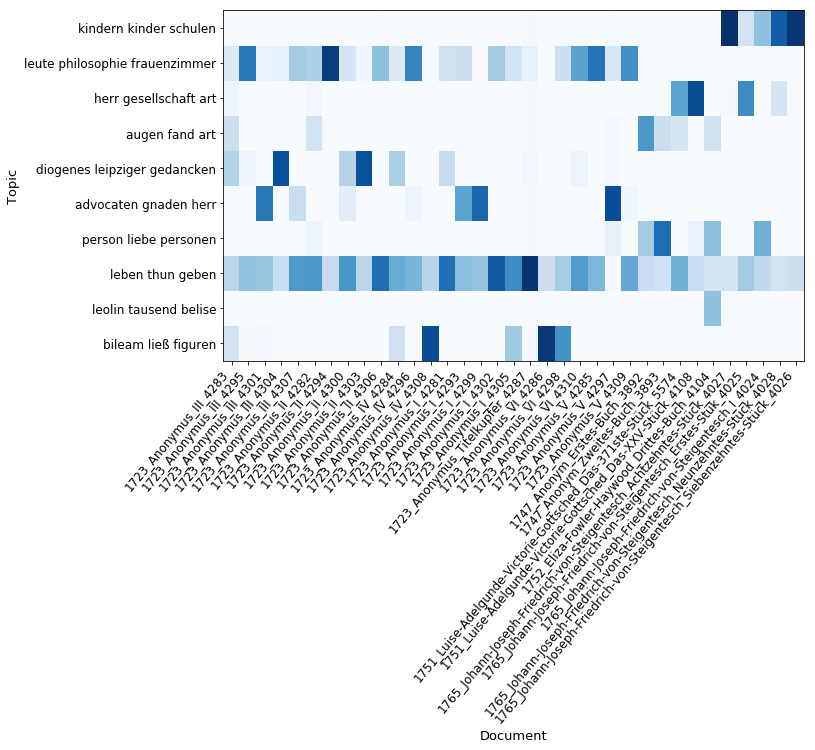

In [30]:
static_heatmap = PlotDocumentTopics.static_heatmap()
static_heatmap.show()

<font color=orange>To see the topic distribution for a specific document, write in its file name in quotation marks or simply its index (example: `0`).</font>

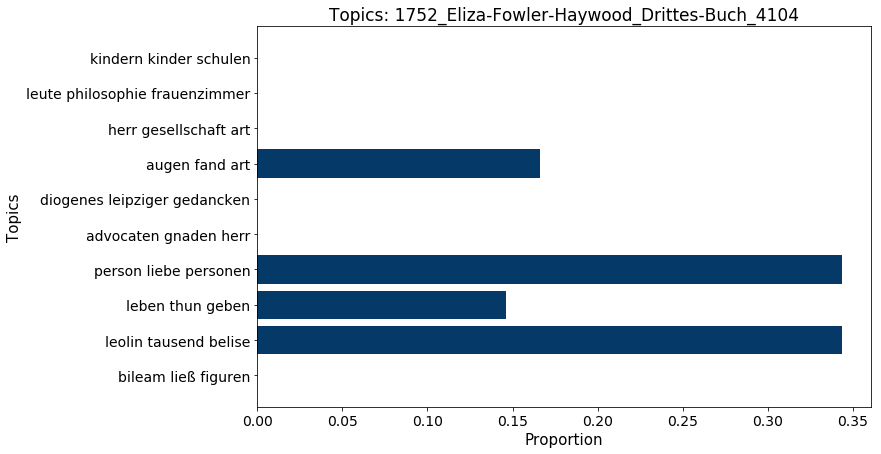

In [66]:
static_barchart_per_document = PlotDocumentTopics.static_barchart_per_document(index='1752_Eliza-Fowler-Haywood_Drittes-Buch_4104', describer='Topics')

<font color=orange>__To save a static heatmap or barchart, use the function `savefig`:__</font>

In [69]:
static_barchart_per_document.savefig(image_folder + "doc_4101.png", format='png', frameon=True, bbox_inches='tight')

<font color=orange>You can also visualize the distribution of a specific topic in all documents:</font>

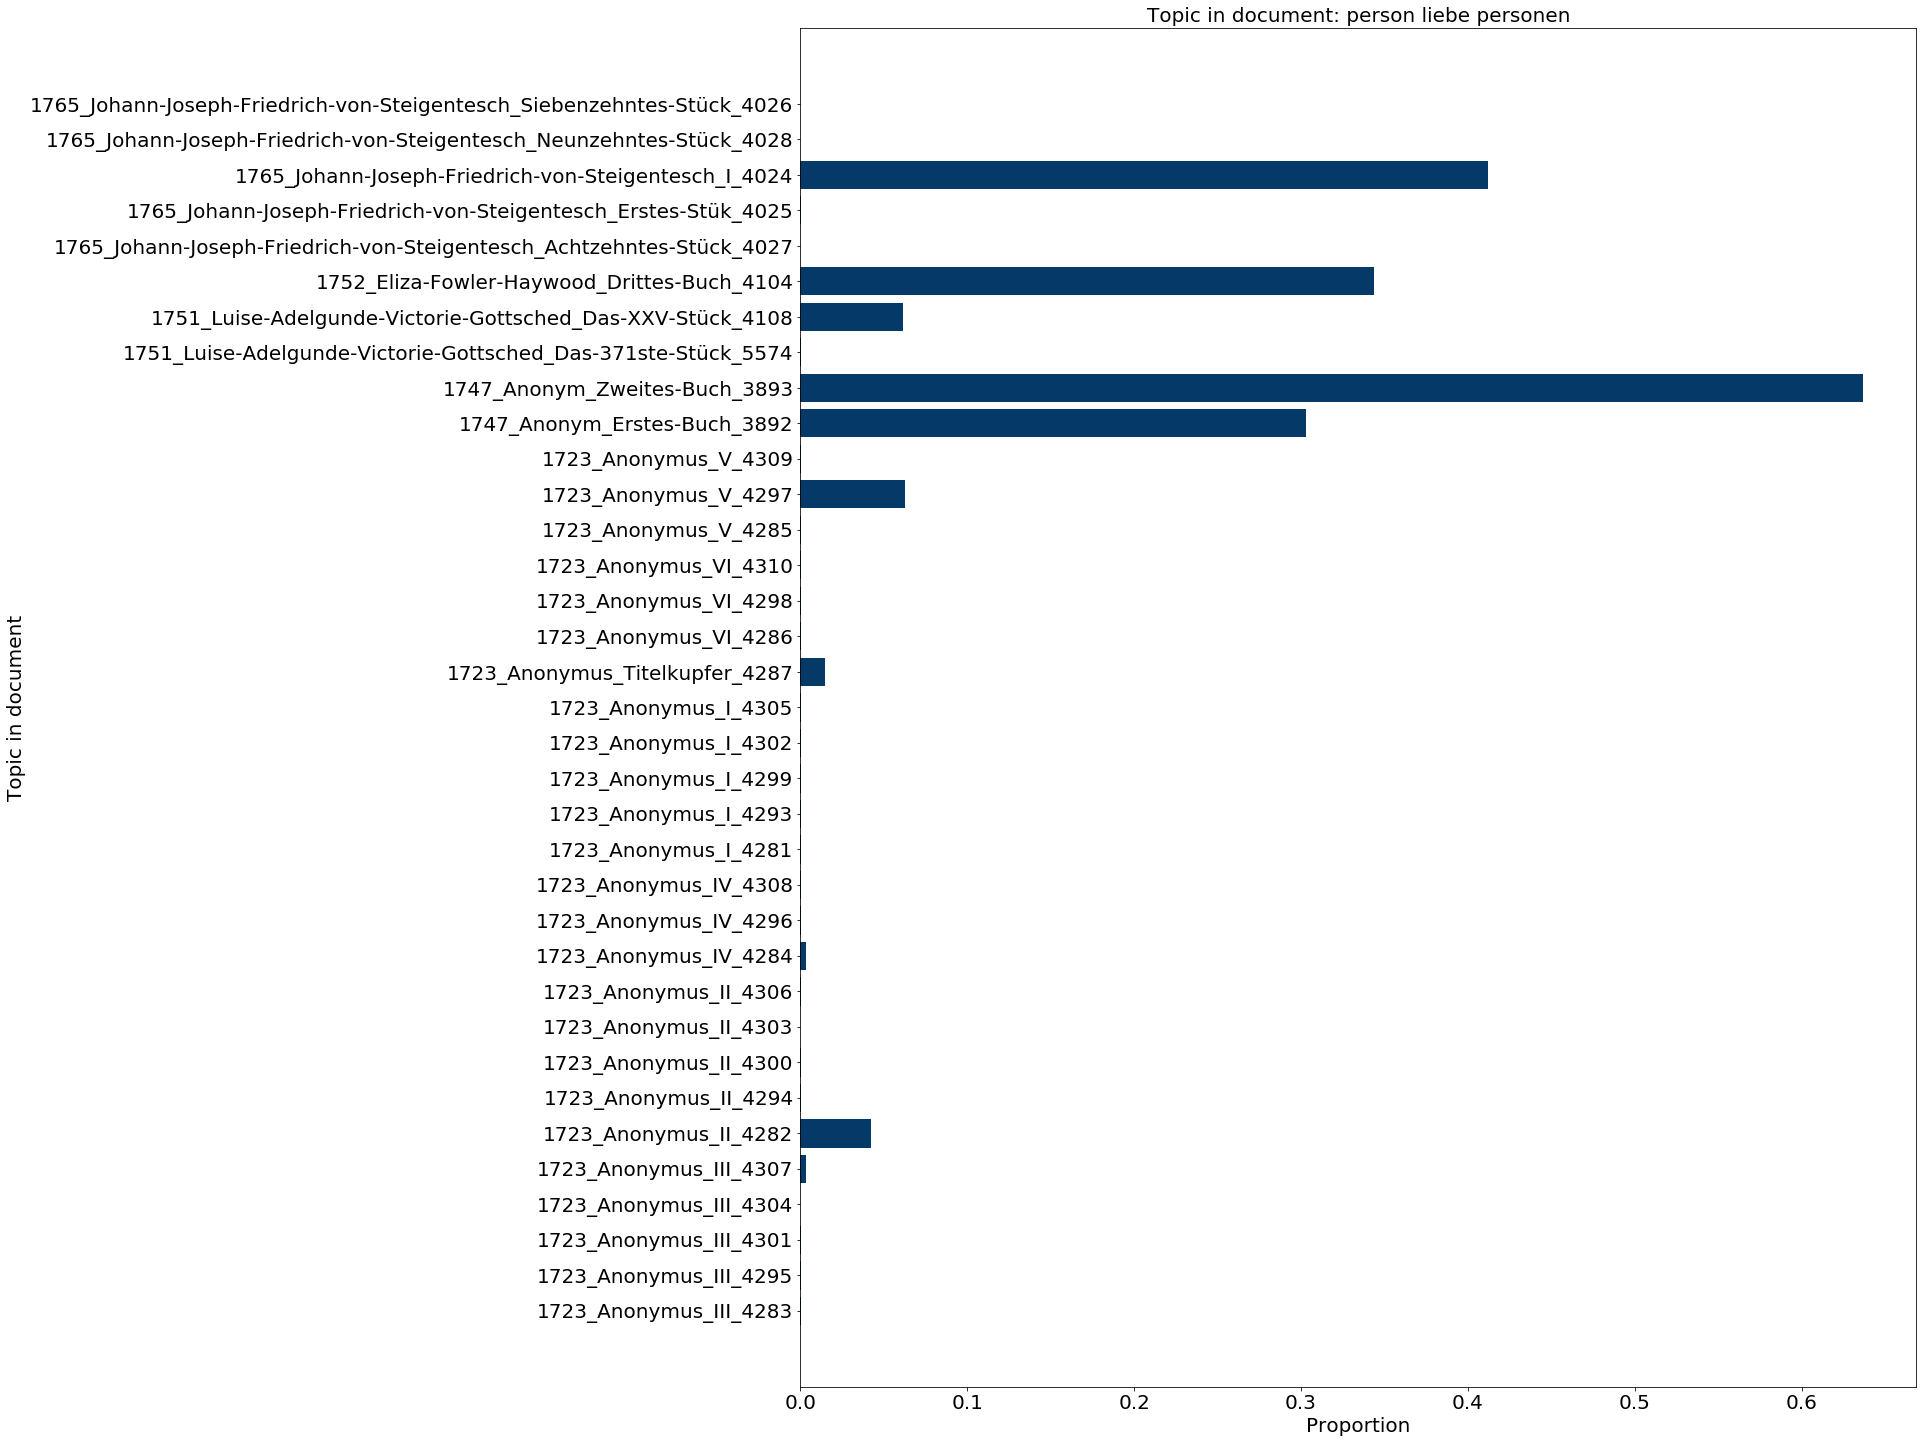

In [89]:
static_barchart_per_topic = PlotDocumentTopics.static_barchart_per_topic(index=3, describer='Topic in document', figsize=(20,25), labels_fontsize='20', ticks_fontsize='20', title_fontsize='20')

In [90]:
static_barchart_per_topic.savefig(image_folder + "topic-in-doc_person-liebe-personen.png", format='png', frameon=True, bbox_inches='tight')

<font color=orange>To check out other options to create or adjust your visalization: </font>

In [44]:
help(PlotDocumentTopics)
#help(static_heatmap)
#help(export_png)

Help on PlotDocumentTopics in module dariah_topics.visualization object:

class PlotDocumentTopics(builtins.object)
 |  PlotDocumentTopics(document_topics)
 |  
 |  Class to visualize document-topic matrix.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, document_topics)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  interactive_barchart_per_document(self, **kwargs)
 |      Plots an interactive barchart per document.
 |      
 |      Args:
 |          index Union(int, str): Index of document-topics matrix column or
 |              name of column.
 |          describer (str): Describer of what the plot shows, e.g. either document
 |              or topic.
 |          bar_color (str), optional: Color of bars. Defaults to ``#053967``.
 |          transpose_data (bool): If True. document-topics matrix will be transposed.
 |              Defaults to False.
 |          title (bool), optional: If True, figure will have a title in the format
 |          

# <font color=orange>Topics grouped by authors</font>

<font color=orange>This part is based on recommendations from [TATOM](https://liferay.de.dariah.eu/tatom/).

Use this code if you wan't to group the resaults by a certain feature, like for example author or year.  
</font>


<font color=orange>Getting the file names and saving in a list:</font>

In [72]:
de_filenames = [os.path.join(path_to_corpus, fn) for fn in sorted(os.listdir(path_to_corpus))]

<font color=orange>Getting author names from file names (depends on the structure of your file names) and saving in a list:</font>

In [73]:
authors = [(os.path.basename(filename).split('_')[1]) for filename in de_filenames]

<font color=orange>Check your authors list:</font>

In [74]:
authors

['Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonymus',
 'Anonym',
 'Anonym',
 'Luise-Adelgunde-Victorie-Gottsched',
 'Luise-Adelgunde-Victorie-Gottsched',
 'Eliza-Fowler-Haywood',
 'Johann-Joseph-Friedrich-von-Steigentesch',
 'Johann-Joseph-Friedrich-von-Steigentesch',
 'Johann-Joseph-Friedrich-von-Steigentesch',
 'Johann-Joseph-Friedrich-von-Steigentesch',
 'Johann-Joseph-Friedrich-von-Steigentesch']

<font color=orange>Turn the authors list into a set of unique names and sort them alphabetically:</font>

In [75]:
authors_unique = sorted(set(authors))
authors_unique

['Anonym',
 'Anonymus',
 'Eliza-Fowler-Haywood',
 'Johann-Joseph-Friedrich-von-Steigentesch',
 'Luise-Adelgunde-Victorie-Gottsched']

<font color=orange>Use the `document_topics matrix` to create a `document_topics_authors` -- a new matrix with the mean value for each author.</font>

In [76]:
document_topics_authors = document_topics.groupby(authors, axis=1).mean().values

In [77]:
document_topics_authors

array([[0.00000e+00, 1.11008e-01, 0.00000e+00, 6.00000e-04, 2.00000e-04],
       [4.50000e-04, 4.24000e-04, 3.43600e-01, 1.00000e-04, 5.00000e-05],
       [1.82500e-01, 3.97516e-01, 1.46400e-01, 2.07040e-01, 2.99300e-01],
       [4.69850e-01, 5.16400e-03, 3.43600e-01, 8.24800e-02, 3.09000e-02],
       [0.00000e+00, 1.13580e-01, 0.00000e+00, 3.80000e-04, 2.00000e-04],
       [1.00000e-04, 1.04180e-01, 0.00000e+00, 5.40000e-04, 2.00000e-04],
       [3.46750e-01, 1.46800e-02, 1.66200e-01, 2.80000e-04, 7.04500e-02],
       [0.00000e+00, 3.28800e-03, 0.00000e+00, 1.38400e-01, 5.97750e-01],
       [3.50000e-04, 2.48876e-01, 1.00000e-04, 1.70000e-03, 7.50000e-04],
       [0.00000e+00, 1.27200e-03, 0.00000e+00, 5.68440e-01, 1.50000e-04]])

<font color=orange>Transform the `document_topics_authors` into a Pandas DataFrame Object:</font>

In [78]:
document_topics_authors = pd.DataFrame(data=document_topics_authors, columns=authors_unique, index=document_topics.index)

In [79]:
document_topics_authors

,Anonym,Anonymus,Eliza-Fowler-Haywood,Johann-Joseph-Friedrich-von-Steigentesch,Luise-Adelgunde-Victorie-Gottsched
bileam ließ figuren,0.00000,0.111008,0.0000,0.00060,0.00020
leolin tausend belise,0.00045,0.000424,0.3436,0.00010,0.00005
leben thun geben,0.18250,0.397516,0.1464,0.20704,0.29930
person liebe personen,0.46985,0.005164,0.3436,0.08248,0.03090
advocaten gnaden herr,0.00000,0.113580,0.0000,0.00038,0.00020
diogenes leipziger gedancken,0.00010,0.104180,0.0000,0.00054,0.00020
augen fand art,0.34675,0.014680,0.1662,0.00028,0.07045
herr gesellschaft art,0.00000,0.003288,0.0000,0.13840,0.59775
leute philosophie frauenzimmer,0.00035,0.248876,0.0001,0.00170,0.00075
kindern kinder schulen,0.00000,0.001272,0.0000,0.56844,0.00015


<font color=orange>__Now you can use the same visualization methods from above with your new matrix `document_topics_authors`!__</font>

### 3.1. Distribution of topics

#### Distribution of topics over all documents

The distribution of topics over all documents can now be visualized in an interactive heatmap.

In [91]:
PlotDocumentTopics = visualization.PlotDocumentTopics(document_topics_authors)
show(PlotDocumentTopics.interactive_heatmap(width=2000, height=1600, major_label_text_font_size='20pt'), notebook_handle=True)


In [81]:
export_png(PlotDocumentTopics.interactive_heatmap(width=2000, height=1600, major_label_text_font_size='20pt'), filename=image_folder + "heatmap_authors.png")

'Y:\\data\\projekte\\dispecs\\topicModelling\\TM_de\\Dariah IntroducingMallet\\test\\heatmap_authors.png'

Or a static heatmap:

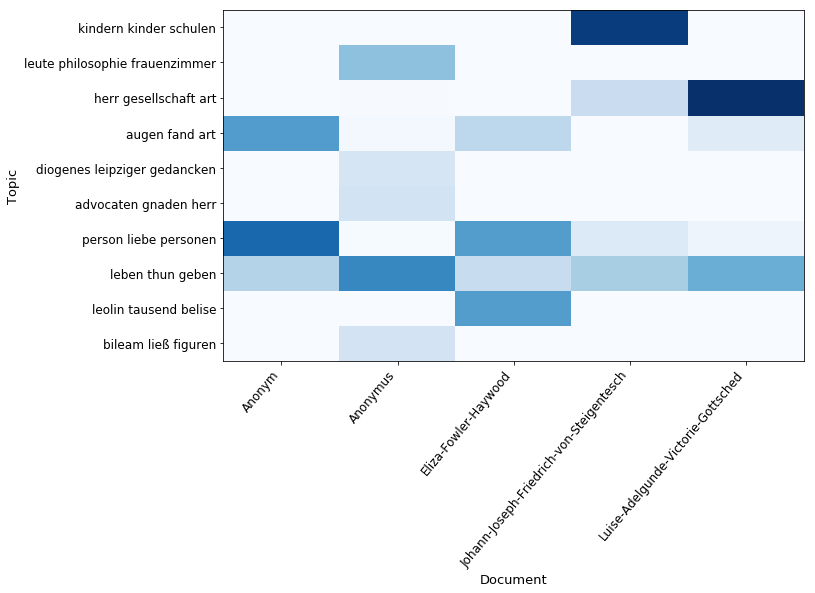

In [82]:
static_heatmap = PlotDocumentTopics.static_heatmap()
static_heatmap.show()

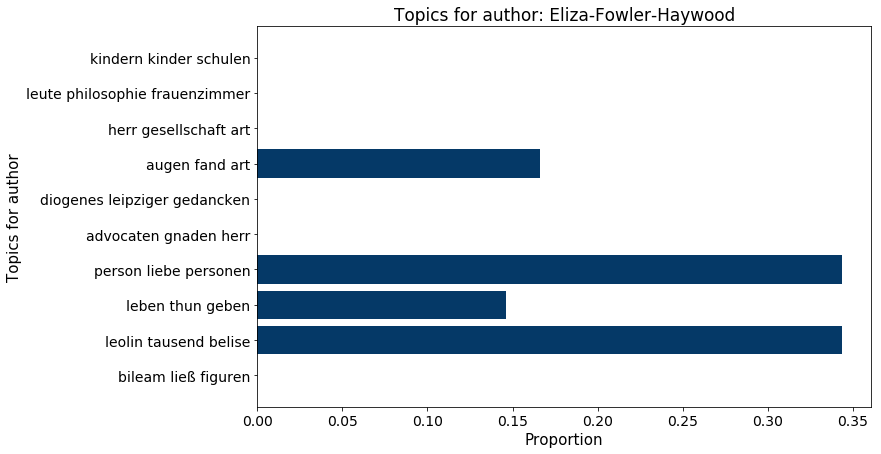

In [83]:
static_barchart_per_document = PlotDocumentTopics.static_barchart_per_document(index=2,
                                                                               describer='Topics for author',
                                                                               )

In [85]:
static_barchart_per_document.savefig(image_folder + "author_haywood.png", format='png', frameon=True, bbox_inches='tight')

In [ ]:
help(PlotDocumentTopics)

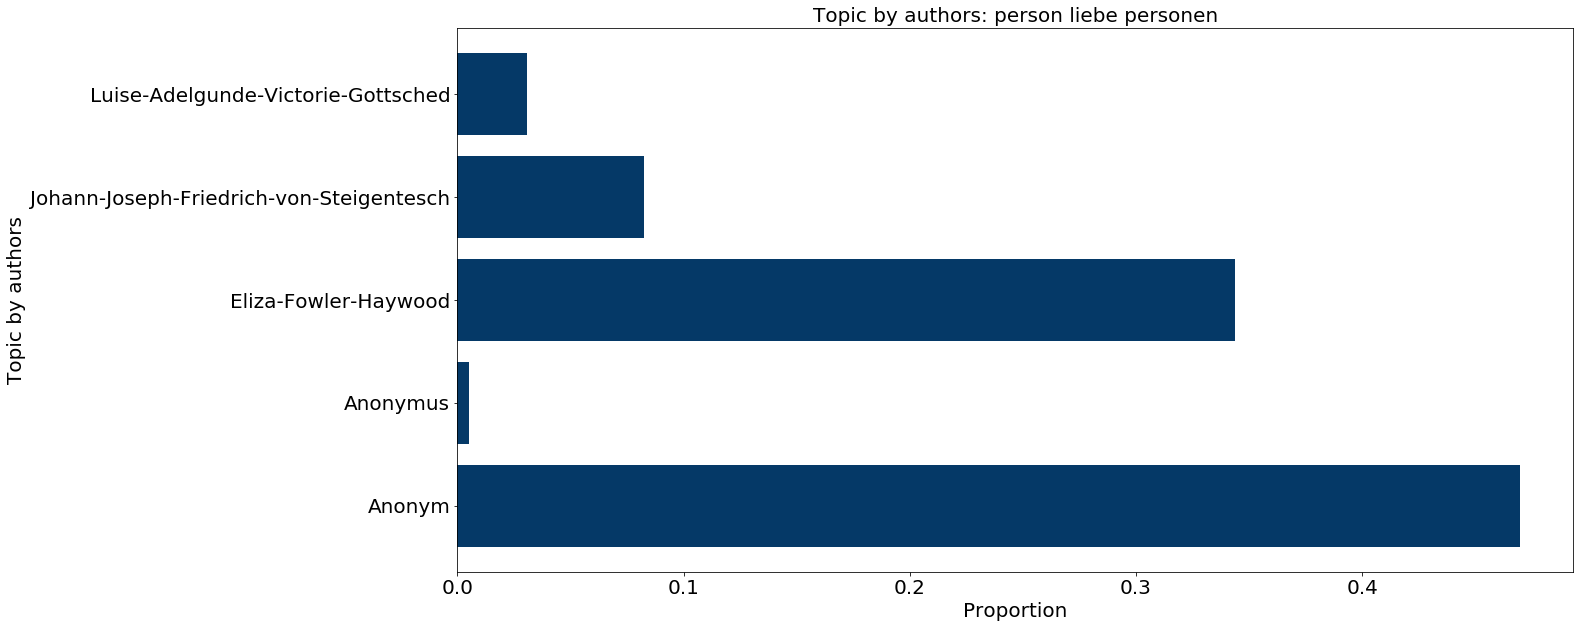

In [92]:
static_barchart_per_topic = PlotDocumentTopics.static_barchart_per_topic(index=3, describer='Topic by authors', figsize=(20,10), labels_fontsize='20', ticks_fontsize='20', title_fontsize='20')

In [93]:
static_barchart_per_topic.savefig(image_folder + "topic-in-authors_person-liebe-personen.png", format='png', frameon=True, bbox_inches='tight')

In [ ]:
"""
topic_over_time(self, metadata_df, threshold=0.1, starttime=1841, endtime=1920)
 |      Creates a visualization that shows topics over time.
 |      
 |      Description:
 |          With this function you can plot topics over time using metadata stored in the documents name.
 |          Only works with mallet output.
 |      
 |      Args:
 |          metadata_df(pd.Dataframe()): metadata created by metadata_toolbox
 |          threshold(float): threshold set to define if a topic in a document is viable
 |          starttime(int): sets starting point for visualization
 |          endtime(int): sets ending point for visualization
 |      
 |      
 |      Returns: 
 |          matplotlib plot
 |      
 |      Note: this function is created for a corpus with filenames that looks like:
 |              1866_ArticleName.txt
"""
#Funktioniert nicht! 
#topic_over_time = PlotDocumentTopics.topic_over_time(metadata_df=meta, threshold=0.1, starttime=1723, endtime=1765)